In [3]:
import numpy as np
import time
import itertools as it

import matplotlib.pylab as plt
import matplotlib.lines as mlines
import matplotlib as mpl
import matplotlib.ticker as ticker
from matplotlib.animation import FuncAnimation
import pickle

# import kmos_tools as KT
import reionizer
import pandas as pd
import scipy.interpolate
import os, sys
import scipy
from scipy import interpolate, integrate
from scipy.integrate import ode, solve_ivp, odeint

# import corner
from astropy.cosmology import Planck15, z_at_value
import astropy.units as u
import astropy.constants as const

from matplotlib import rc_file
rc_file(os.environ['WORK_DIR']+'/code/matplotlibrc')

%matplotlib inline

import seaborn as sns

plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = (4,4)

sys.path.append('../')
import bubbles

In [2]:
%load_ext autoreload
%autoreload 2

# Compare Malhotra & Rhoads 2006

https://ui.adsabs.harvard.edu/abs/2006ApJ...647L..95M/abstract, same as from Dijkstra 2014

$$ \tau_{MR06} = 1.2 \mathrm{pMpc}\left(\frac{R_b}{1 + z} + \frac{\Delta v}{H(z)}\right)^{-1} $$

My transmission is always higher, why? My optical depth is ~0.86x lower

Test | Outcome
-----|---------
[Change tau z integration limits](#Tau-integration-limits) | Integrating from 0 helps a little, but not significant
[Increase x spacing](#Increase-x-spacing-in-tau-integral) | No difference
[Cosmology](#Check-cosmology) | <2% difference


In [4]:
def tau_damp_MR06(DV, z_s, Rb, useHapprox=False):
    """Malhotra & Rhoads 2006 Lya damping wing
    
    Input Rb in cMpc
    
    """
    if useHapprox:
        Happrox = 760*((1.+z_s)/7.5)**1.5 * u.km/u.s/u.Mpc
        return 1.2*u.Mpc/(Rb/(1+z_s) + DV/Happrox).to(u.Mpc)
    else:
        return 1.2*u.Mpc/(Rb/(1+z_s) + DV/Planck15.H(z_s)).to(u.Mpc)

In [5]:
wave_em = np.linspace(1210, 1220., 1000) * u.Angstrom
DV_tab  = bubbles.wave_to_DV(wave_em)

# Compare my basic model to theirs

In [20]:
z_min      = 6.  # minimum redshift for integral
z_s        = 8.
Ndot_ion   = 2.e57 / u.s
source_age = 1e8 * u.year

R_ion = bubbles.R_bubble_CenHaiman2000(z_s=z_s, Ndot_ion=Ndot_ion, t_source=source_age)
z_ion = bubbles.z_at_comoving_distance(R_ion, z_1=z_s)

# damping wing in IGM
tau_IGM = bubbles.optical_depth(wave_em, z_min=z_min, z_max=z_ion, z_s=z_s,
                                inside_HII=False, T=1.*u.K, Ndot_ion=Ndot_ion)

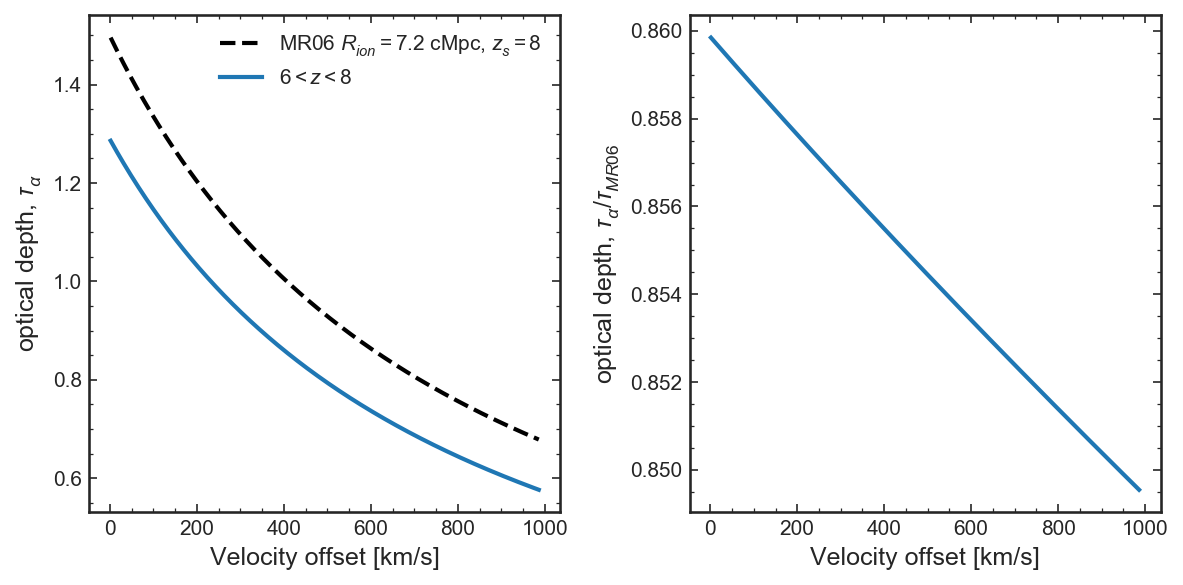

In [31]:
MR06_tau = tau_damp_MR06(DV_tab[DV_tab > 0.], Rb=R_ion, z_s=z_s)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4), sharex=True)

ax1.plot(DV_tab[DV_tab > 0.], MR06_tau, c='k', ls='dashed', 
         label='MR06 $R_{ion} = %.1f$ cMpc, $z_s=%.0f$' % (R_ion.value, z_s))

ax1.plot(DV_tab[DV_tab > 0.], tau_IGM[DV_tab > 0.], label='$%.0f < z < %.0f$' % (z_min, z_s))

# Ratio
ax2.plot(DV_tab[DV_tab > 0.], tau_IGM[DV_tab > 0.]/MR06_tau, label='$%.0f < z < %.0f$' % (z_min, z_s))

ax1.legend()
ax1.set_xlabel('Velocity offset [km/s]')
ax2.set_xlabel('Velocity offset [km/s]')
ax1.set_ylabel(r'optical depth, $\tau_\alpha$')
ax2.set_ylabel(r'optical depth, $\tau_\alpha/\tau_{MR06}$')
fig.tight_layout()

# Assume n_H is constant

In [37]:
def optical_depth_constant_nH(wave_em, T, z_min, z_max, z_s=7.,
                  inside_HII=True, C_HII=3., xtab_len=100,
                  Ndot_ion=1.e57/u.s):
    """
    Lya optical depth as a function of wavelength 
    using definition of optical depth and Lya cross-section
    """
    crosssec = bubbles.lya_cross_section(T)   
    
    # Redshift array
    ztab_ends = np.array([z_min, z_max])
    
    # Observed wavelength
    wave_obs = wave_em * (1. + z_s)
        
    # Range of redshifted wavelength and x
    wave_z_ends = wave_obs[:,None]/(1+ztab_ends)
    x_z_ends    = crosssec.Lya_wave_to_x(wave_z_ends)
    
    tau = np.zeros(len(wave_obs))
    for ww, w_obs in enumerate(wave_obs):
                
        # Make xtab 
        if (x_z_ends[ww] < 0).all():
            xtab = -np.logspace(np.log10(-x_z_ends[ww].min()),np.log10(-x_z_ends[ww].max()),xtab_len)
            xtab = np.sort(xtab)
        elif (x_z_ends[ww] > 0).all():
            xtab = np.logspace(np.log10(x_z_ends[ww].min()),np.log10(x_z_ends[ww].max()),xtab_len)
            xtab = np.sort(xtab)
        else:       
            xtab_neg = -np.logspace(-1,np.log10(-x_z_ends[ww].min()),int(xtab_len/2))
            xtab_pos = np.logspace(-1,np.log10(x_z_ends[ww].max()),int(xtab_len/2))
            xtab     = np.sort(np.concatenate((xtab_neg, xtab_pos)))
        
        # Get wave_redshift
        wave_redshift = crosssec.Lya_x_to_wave(xtab)

        # Get z tab
        ztab = w_obs/wave_redshift - 1.

        # Residual neutral fraction
        if inside_HII:
            r   = bubbles.comoving_distance_from_source_Mpc(ztab, z_s)
            xHI = bubbles.xHI_R(r, z_s, fesc=0.5*Ndot_ion/(1.e57/u.s), C=C_HII, T=T.value) # Only source flux
        else:
            xHI = 1.
            
        # Cross-section
        lya_cross = crosssec.Lya_crosssec_x(xtab)
                           
        # Calculate optical depth
        prefac = (const.c * bubbles.dt_dz(ztab) * xHI * bubbles.n_H(z_s)).to(1./u.cm**2.)
        dtau   = prefac * lya_cross
    
        tau[ww] = np.trapz(dtau, ztab)
        
    return tau

In [39]:
z_min      = 6.  # minimum redshift for integral
z_s        = 8.
Ndot_ion   = 2.e57 / u.s
source_age = 1e8 * u.year

R_ion = bubbles.R_bubble_CenHaiman2000(z_s=z_s, Ndot_ion=Ndot_ion, t_source=source_age)
z_ion = bubbles.z_at_comoving_distance(R_ion, z_1=z_s)

# damping wing in IGM
tau_IGM_constant_nH = optical_depth_constant_nH(wave_em, z_min=z_min, z_max=z_ion, z_s=z_s,
                                                inside_HII=False, T=1.*u.K, Ndot_ion=Ndot_ion)

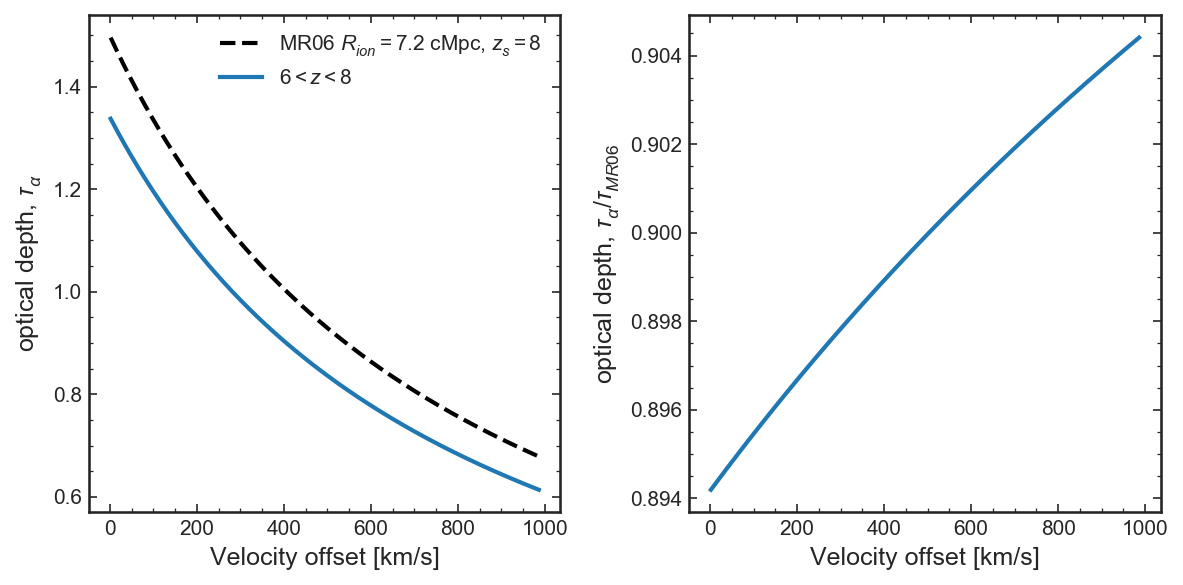

In [40]:
MR06_tau = tau_damp_MR06(DV_tab[DV_tab > 0.], Rb=R_ion, z_s=z_s)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4), sharex=True)

ax1.plot(DV_tab[DV_tab > 0.], MR06_tau, c='k', ls='dashed', 
         label='MR06 $R_{ion} = %.1f$ cMpc, $z_s=%.0f$' % (R_ion.value, z_s))

ax1.plot(DV_tab[DV_tab > 0.], tau_IGM_constant_nH[DV_tab > 0.], label='$%.0f < z < %.0f$' % (z_min, z_s))

# Ratio
ax2.plot(DV_tab[DV_tab > 0.], tau_IGM_constant_nH[DV_tab > 0.]/MR06_tau, label='$%.0f < z < %.0f$' % (z_min, z_s))

ax1.legend()
ax1.set_xlabel('Velocity offset [km/s]')
ax2.set_xlabel('Velocity offset [km/s]')
ax1.set_ylabel(r'optical depth, $\tau_\alpha$')
ax2.set_ylabel(r'optical depth, $\tau_\alpha/\tau_{MR06}$')
fig.tight_layout()

# Increase x spacing in tau integral

No difference

In [35]:
z_min      = 6.  # minimum redshift for integral
z_s        = 8.
Ndot_ion   = 2.e57 / u.s
source_age = 1e8 * u.year

R_ion = bubbles.R_bubble_CenHaiman2000(z_s=z_s, Ndot_ion=Ndot_ion, t_source=source_age)
z_ion = bubbles.z_at_comoving_distance(R_ion, z_1=z_s)

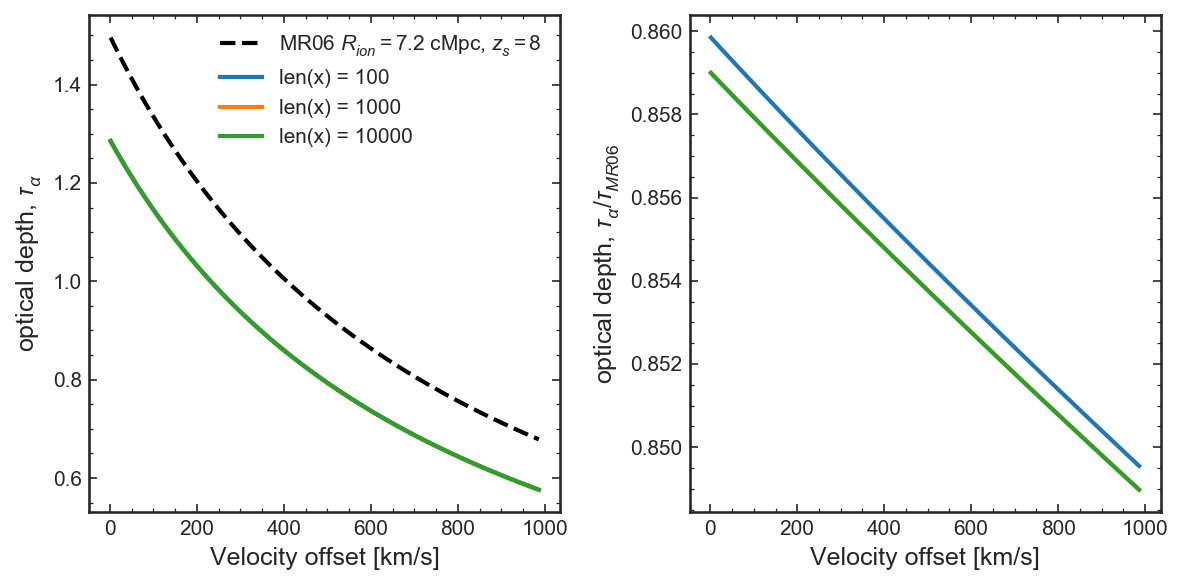

In [36]:
MR06_tau = tau_damp_MR06(DV_tab[DV_tab > 0.], Rb=R_ion, z_s=z_s)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4), sharex=True)

ax1.plot(DV_tab[DV_tab > 0.], MR06_tau, c='k', ls='dashed', 
         label='MR06 $R_{ion} = %.1f$ cMpc, $z_s=%.0f$' % (R_ion.value, z_s))

# Change zmin
for x_len in [100, 1000, 10000]:
    tau_IGM = bubbles.optical_depth(wave_em, z_min=z_min, z_max=z_ion, z_s=z_s, xtab_len=x_len,
                                    inside_HII=False, T=1.*u.K, Ndot_ion=Ndot_ion)
    ax1.plot(DV_tab[DV_tab > 0.], tau_IGM[DV_tab > 0.], label='len(x) = %i' % (x_len))

    # Ratio
    ax2.plot(DV_tab[DV_tab > 0.], tau_IGM[DV_tab > 0.]/MR06_tau)

ax1.legend()
ax1.set_xlabel('Velocity offset [km/s]')
ax2.set_xlabel('Velocity offset [km/s]')
ax1.set_ylabel(r'optical depth, $\tau_\alpha$')
ax2.set_ylabel(r'optical depth, $\tau_\alpha/\tau_{MR06}$')
fig.tight_layout()

# Tau integration limits

Integrating from zero helps a bit but not all the way

In [33]:
z_min      = 6.  # minimum redshift for integral
z_s        = 8.
Ndot_ion   = 2.e57 / u.s
source_age = 1e8 * u.year

R_ion = bubbles.R_bubble_CenHaiman2000(z_s=z_s, Ndot_ion=Ndot_ion, t_source=source_age)
z_ion = bubbles.z_at_comoving_distance(R_ion, z_1=z_s)

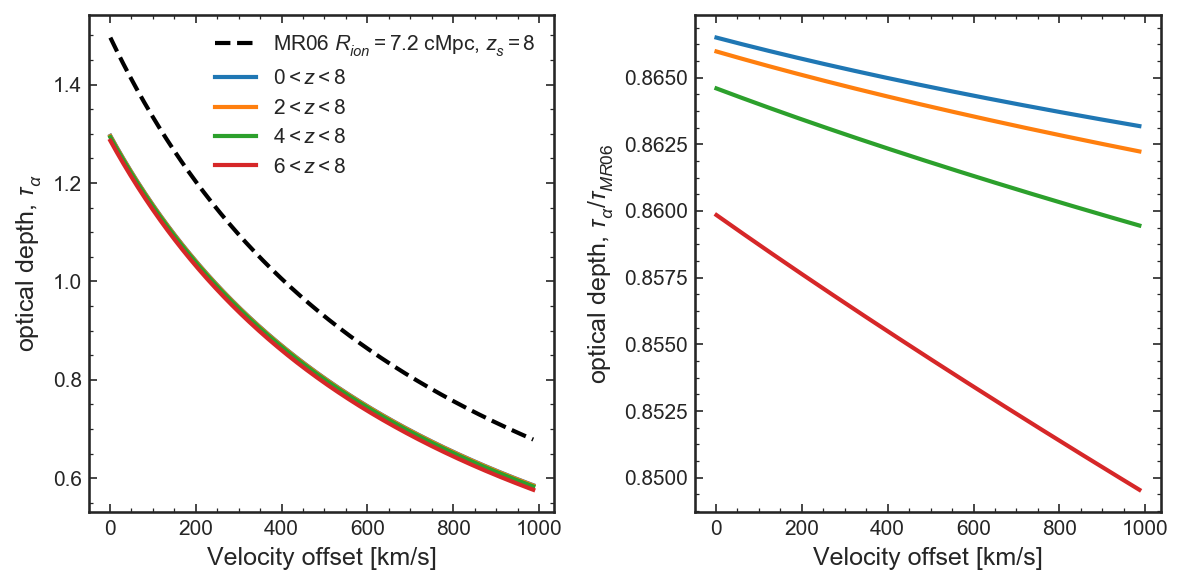

In [34]:
MR06_tau = tau_damp_MR06(DV_tab[DV_tab > 0.], Rb=R_ion, z_s=z_s)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4), sharex=True)

ax1.plot(DV_tab[DV_tab > 0.], MR06_tau, c='k', ls='dashed', 
         label='MR06 $R_{ion} = %.1f$ cMpc, $z_s=%.0f$' % (R_ion.value, z_s))

# Change zmin
for z_min in [0., 2., 4., 6.]:
    tau_IGM = bubbles.optical_depth(wave_em, z_min=z_min, z_max=z_ion, z_s=z_s,
                                    inside_HII=False, T=1.*u.K, Ndot_ion=Ndot_ion)
    ax1.plot(DV_tab[DV_tab > 0.], tau_IGM[DV_tab > 0.], label='$%.0f < z < %.0f$' % (z_min, z_s))

    # Ratio
    ax2.plot(DV_tab[DV_tab > 0.], tau_IGM[DV_tab > 0.]/MR06_tau, 
             label='$%.0f < z < %.0f$' % (z_min, z_s))

ax1.legend()
ax1.set_xlabel('Velocity offset [km/s]')
ax2.set_xlabel('Velocity offset [km/s]')
ax1.set_ylabel(r'optical depth, $\tau_\alpha$')
ax2.set_ylabel(r'optical depth, $\tau_\alpha/\tau_{MR06}$')
fig.tight_layout()

# Check cosmology

Not significant

Text(0, 0.5, 'optical depth, $\\tau_\\alpha$')

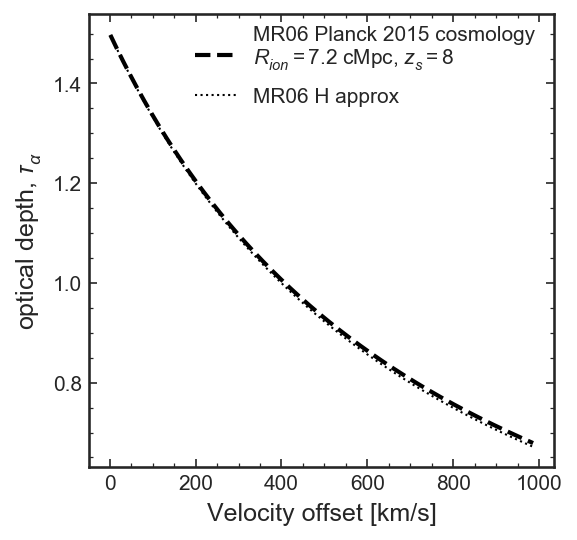

In [25]:
z_s   = 8.
R_ion = 7.2*u.Mpc

plt.plot(DV_tab[DV_tab > 0.], tau_damp_MR06(DV_tab[DV_tab > 0.], Rb=R_ion, z_s=z_s), 
         c='k', ls='dashed', label='MR06 Planck 2015 cosmology\n$R_{ion} = %.1f$ cMpc, $z_s=%.0f$' % (R_ion.value, z_s))

plt.plot(DV_tab[DV_tab > 0.], tau_damp_MR06(DV_tab[DV_tab > 0.], Rb=R_ion, z_s=z_s, useHapprox=True), 
         c='k', ls='dotted', lw=1, label='MR06 H approx')

plt.legend()
plt.xlabel('Velocity offset [km/s]')
plt.ylabel(r'optical depth, $\tau_\alpha$')

In [2]:
xtab_len = 100





for z_min in [6., 5., 4., 0.]:
    tau_IGM = optical_depth(wave_em, z_min=z_min, z_max=z_ion, z_s=z_s, xtab_len=xtab_len,
                        inside_HII=False, T=1.*u.K, Ndot_ion=Ndot_ion)
    plt.plot(DV_tab[DV_tab > 0.], tau_IGM[DV_tab > 0.], label='$%.1f < z < %.1f$' % (z_min, z_s))

plt.plot(DV_tab[DV_tab > 0.], tau_damp_MR06(DV_tab[DV_tab > 0.], Rb=R_ion, z=z_s), 
         c='k', ls='dashed', label='Malhotra & Rhoads 2006')
plt.plot(DV_tab[DV_tab > 0.], tau_damp_MR06(DV_tab[DV_tab > 0.], Rb=R_ion, z=z_s, useHapprox=True), 
         c='k', ls='dotted', lw=1, label='MR06 H approx')


# plt.annotate('$\tau =')
plt.legend()
plt.xlabel('Velocity offset [km/s]')
plt.ylabel(r'optical depth, $\tau_\alpha$')


plt.figure()

for z_min in [6., 5., 4., 0.]:
    tau_IGM = optical_depth(wave_em, z_min=z_min, z_max=z_ion, z_s=z_s, xtab_len=xtab_len,
                        inside_HII=False, T=1.*u.K, Ndot_ion=Ndot_ion)
    plt.plot(DV_tab[DV_tab > 0.], tau_IGM[DV_tab > 0.]/tau_damp_MR06(DV_tab[DV_tab > 0.], Rb=R_ion, z=z_s), 
             label='$%.1f < z < %.1f$' % (z_min, z_s))


# plt.annotate('$\tau =')
plt.legend()
plt.xlabel('Velocity offset [km/s]')
plt.ylabel(r'optical depth, $\tau_\alpha/\tau_{MR06}$')

NameError: name 'wave_em' is not defined